In [1]:
import numpy as np
np.bool = np.bool_
import pyemma.msm as msm
import pyemma.plots as mplt
import matplotlib as mt
import matplotlib.pyplot as plt
import MDAnalysis as mda
import sys
sys.path.append('../0_python_modules/')
import msm_analysis as ana

### urf_h2
<font size=4>
    <br>
    for pc=3 <br>
    i = 3 <br>
    cl = 30, 50, 500, 700, 1000 <br>
    ml = 40 <br>
    <br>
    <br>
    for pc = 4 <br>
    i=0 <br>
    20, 5   # cl, ml <br> 
    30, 10 <br>
    30, 15 <br>
    1500, 10 <br>
    <br>
    i=1 <br>
    20, 45 <br>
    <br>
    i=4 <br>
    250, 5 <br>
    350, 10 <br>
    <br>

In [2]:
colors = np.array(['salmon', 'dodgerblue', 'teal', 'limegreen', 'sienna', 'violet'])
cmaps = [mt.colors.LinearSegmentedColormap.from_list('', colors[:i], N=i) for i in range(3, 7)]

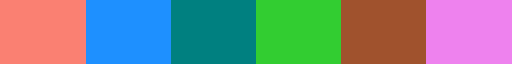

In [3]:
cmaps[3]

In [4]:
trajs = np.array([
    f'LONG_TRAJ/{i}.xtc' for i in ['1f','2_2','2f_1','3_1','3_2','4f','5f']
] + [
    f'SHORT_TRAJ_subunit1/{i}.xtc' for i in range(1,63)
] + [
    f'SHORT_TRAJ_subunit2/{i}.xtc' for i in range(1,41)
] + [
    f'SHORT_TRAJ_intermediate/{i}.xtc' for i in range(1,21)
])
path = '../1_datasets/mopR_bindings/'
pdb = 'p2e.pdb'

In [5]:
def get_frames(model, mdis, dtrj, stds, 
               microstate='large', trj='most'):
    xtcs = []
    frames = []
    for a,macro in enumerate(mdis):
        if microstate=='large':
            micro = macro[ stds[macro].argmax() ]
        else:
            micro = macro[ stds[macro].argmin() ]
            
        nframes = [np.where(dd==micro)[0].shape[0] for dd in dtrj]
        if trj=='most':
            dd = np.argmax(nframes)
        else:
            dd = np.argmin(nframes)
            
        frames.append( np.where(dtrj[dd] == micro)[0] )
        xtcs.append(dd)
        
    return xtcs, frames

In [6]:
def write_frames(path, pdb, trajs, idata,
                tid, fid, nconfs=10, otype='random', sel='all',
                ofmt='pdb', opath='./', oname='frame'):
    
    uni = mda.Universe(f'{path}{pdb}', f'{path}{trajs[tid]}')
    
    dd = idata[tid][fid]
    
    if otype=='random':
        np.random.seed(0)
        oframes = np.random.choice(fid, nconfs)
    elif otype == 'min':
        oframes = fid[dd.argsort()[:nconfs]]
    elif otype == 'max':
        oframes = fid[dd.argsort()[::-1][:nconfs]]
    elif otype == 'variable':
        oframes = fid[dd.argsort()[::int(len(fid)/nconfs)][:nconfs]]
    else:
        raise ValueError(f'{otype} not in [random, variable, min, max]')
        
    for a,i in enumerate(oframes):
        uni.trajectory[i]
        uni.select_atoms(f'{sel}').write(f'{opath}{oname}{a}.{ofmt}')

In [7]:
idata = np.load('../1_datasets/mopR_bindings/distance_alldata.npy', allow_pickle=True)

# h=2, i=3, cl=50, ml=40, pc=3

In [8]:
h=2
i=3
cl=50
ml=40
pc=3

In [9]:
tic2 = np.load(f'ticas/h{h}_tic2_{i}.npz')
tic2 = np.concatenate(([tic2[k] for k in list(tic2)]))

dtrj = np.load(f'urf/saved_h{2}_msm/dtraj_{i}_{cl}.npz')
dtrj = [dtrj[k] for k in list(dtrj)]

model = msm.estimate_markov_model(dtrj, lag=ml)
model.pcca(pc)
mdis=model.metastable_sets
mdis

[array([ 1,  4,  6, 12, 17, 28, 33, 40, 42]),
 array([ 0,  2,  3,  5,  7,  8,  9, 10, 11, 13, 14, 15, 16, 18, 19, 20, 22,
        23, 24, 25, 26, 27, 29, 30, 32, 34, 35, 36, 37, 38, 39, 41, 43, 44,
        45, 46, 47, 48, 49]),
 array([21, 31])]

In [10]:
pr = ana.analyze_msm_clusters(dtrj)
pr.take_data(idata)
means, stds, probs = pr.get_mean()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 129/129 [00:04<00:00, 26.04it/s]


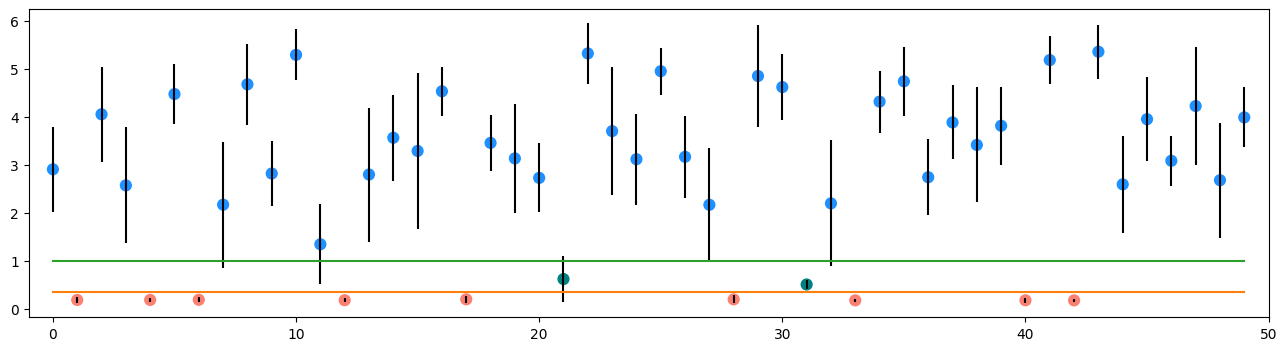

In [11]:
mcolors = np.zeros((cl))
for a,k in enumerate(model.metastable_sets):
    mcolors[k] = a
    
fig,ax=plt.subplots(1, figsize=(16,4))
ax.errorbar(range(cl), means, fmt='.', yerr=stds, ms=0, ecolor='black')
ax.scatter(range(cl), means, c=colors[mcolors.astype(int)], s=60)
ax.plot([0,cl-1],[0.35,0.35])
ax.plot([0,cl-1],[1,1])
ax.set_xlim(-1,cl)
plt.show()

In [11]:
state_labels = ['B','U','I']

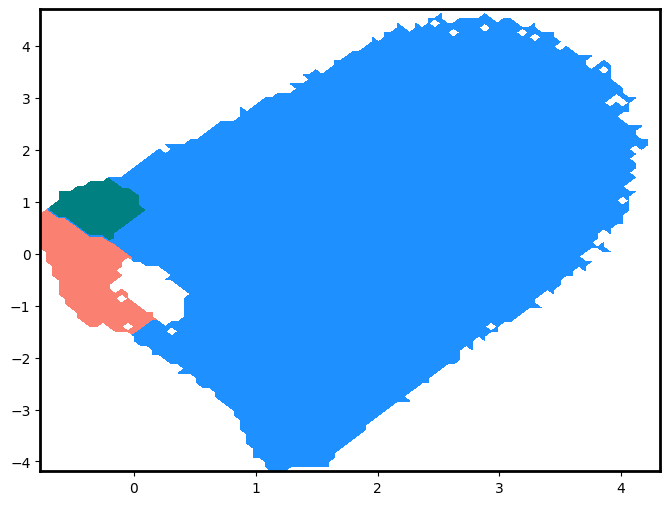

In [13]:
fig,ax=plt.subplots(1,figsize=(8,6))
mplt.plot_state_map(tic2[:,0], tic2[:,1],
                   model.metastable_assignments[np.concatenate((model.dtrajs_active))],
                   cbar=False, cmap=cmaps[pc-3], ax=ax)
ax.spines[:].set_linewidth(2)
plt.savefig(f'plots/statemap_{h}_{i}_{cl}_{ml}_{pc}.pdf')
plt.show()

In [12]:
for a, k in enumerate(mdis): print(a,model.pi[k].sum())

0 0.7619398283454399
1 0.20365211301608718
2 0.034408058638472946


In [13]:
fr = ml * 10 * 10**(-6)
for k in range(pc-1):
    for j in range(k+1,pc):
        print(k,j,model.mfpt(mdis[k], mdis[j])*fr, model.mfpt(mdis[j], mdis[k])*fr)

0 1 19.35710412738313 6.090940418409071
0 2 4.108975657634026 1.2376411872558135
1 2 5.5714792846404855 15.386261217307856


In [14]:
mdtrj = ana.get_mdtrj(dtrj, mdis, output_type='trj')
mmodel = msm.estimate_markov_model(mdtrj, lag=ml)

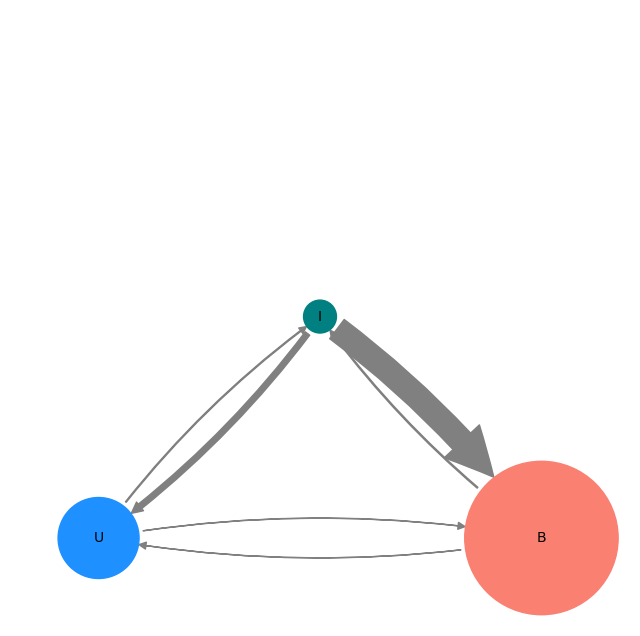

In [20]:
fig,ax=plt.subplots(1, figsize=(8,8))
mplt.plot_markov_model(mmodel, 
                       pos=np.array([[2,0],[0,0],[1,1]]), 
                       state_colors=colors[:pc], state_labels=state_labels, state_scale=4,
                       arrow_labels=None, arrow_scale=3, ax=ax
                      )
plt.savefig(f'plots/markov_model_{h}_{i}_{cl}_{ml}_{pc}.pdf')
plt.show()

In [16]:
flux = msm.tpt(model, mdis[1], mdis[0])
cg, cgflux = flux.coarse_grain(mdis)
print(cgflux.committor)
paths, path_fluxes = cgflux.pathways(fraction=0.99)
for a,i in enumerate(paths):
    print(i, path_fluxes[a]/np.sum(path_fluxes))

[0.         0.78960582 1.        ]
[0 1 2] 0.8187270940981702
[0 2] 0.1812729059018297


In [17]:
fid=get_frames(model, mdis, dtrj, stds)
fid

([3, 1, 123],
 [array([ 55886,  55942,  55949, ..., 152437, 152454, 168403]),
  array([  2805,   2810,   2813, ..., 317700, 317701, 317702]),
  array([    1,     2,     3, ...,  9997,  9999, 10000])])

In [20]:
for i in zip(fid[0], fid[1], ['min','variable','max'], ['bound','unbound','int']):
    write_frames(path=path, pdb=pdb, trajs=trajs, idata=idata,
                tid=i[0], fid=i[1], nconfs=20, otype=i[2], sel='all',
                opath='saved_MSM3/', oname=i[3])

# h=2, i=3, cl=30, ml=40, pc=3

In [51]:
h=2
i=3
cl=30
ml=40
pc=3

In [52]:
tic2 = np.load(f'ticas/h{h}_tic2_{i}.npz')
tic2 = np.concatenate(([tic2[k] for k in list(tic2)]))

dtrj = np.load(f'urf/saved_h{2}_msm/dtraj_{i}_{cl}.npz')
dtrj = [dtrj[k] for k in list(dtrj)]

model = msm.estimate_markov_model(dtrj, lag=ml)
model.pcca(pc)
mdis=model.metastable_sets
mdis

[array([ 0,  2,  3,  5,  7,  8,  9, 10, 11, 13, 14, 15, 16, 18, 19, 20, 22,
        23, 24, 25, 26, 27, 29]),
 array([21]),
 array([ 1,  4,  6, 12, 17, 28])]

In [53]:
pr = ana.analyze_msm_clusters(dtrj)
pr.take_data(np.load('../1_datasets/mopR_bindings/distance_alldata.npy', allow_pickle=True))
means, stds, probs = pr.get_mean()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 129/129 [00:04<00:00, 25.97it/s]


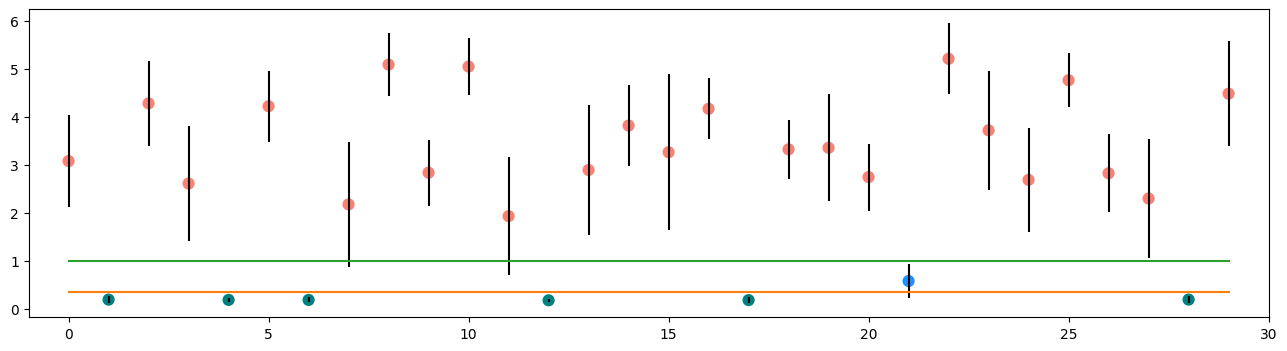

In [54]:
mcolors = np.zeros((cl))
for a,k in enumerate(model.metastable_sets):
    mcolors[k] = a
    
fig,ax=plt.subplots(1, figsize=(16,4))
ax.errorbar(range(cl), means, fmt='.', yerr=stds, ms=0, ecolor='black')
ax.scatter(range(cl), means, c=colors[mcolors.astype(int)], s=60)
ax.plot([0,cl-1],[0.35,0.35])
ax.plot([0,cl-1],[1,1])
ax.set_xlim(-1,cl)
plt.show()

In [55]:
state_labels = ['U','I','B']

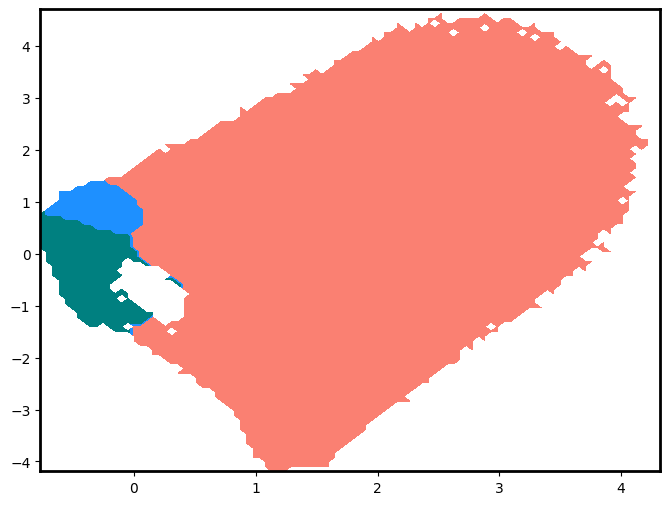

In [56]:
fig,ax=plt.subplots(1,figsize=(8,6))
mplt.plot_state_map(tic2[:,0], tic2[:,1],
                   model.metastable_assignments[np.concatenate((model.dtrajs_active))],
                   cbar=False, cmap=cmaps[pc-3], ax=ax)
ax.spines[:].set_linewidth(2)
plt.savefig(f'plots/statemap_{h}_{i}_{cl}_{ml}_{pc}.pdf')
plt.show()

In [57]:
for a, k in enumerate(mdis): print(a,model.pi[k].sum())

0 0.21069180728348283
1 0.03122884386134821
2 0.7580793488551687


In [58]:
fr = ml * 10 * 10**(-6)
for k in range(pc-1):
    for j in range(k+1,pc):
        print(k,j,model.mfpt(mdis[k], mdis[j])*fr, model.mfpt(mdis[j], mdis[k])*fr)

0 1 4.934203103338578 12.140997157308382
0 2 5.154771787139137 16.1174532388995
1 2 1.2681672810813795 4.992796421970189


In [59]:
mdtrj = ana.get_mdtrj(dtrj, mdis, output_type='trj')
mmodel = msm.estimate_markov_model(mdtrj, lag=ml)

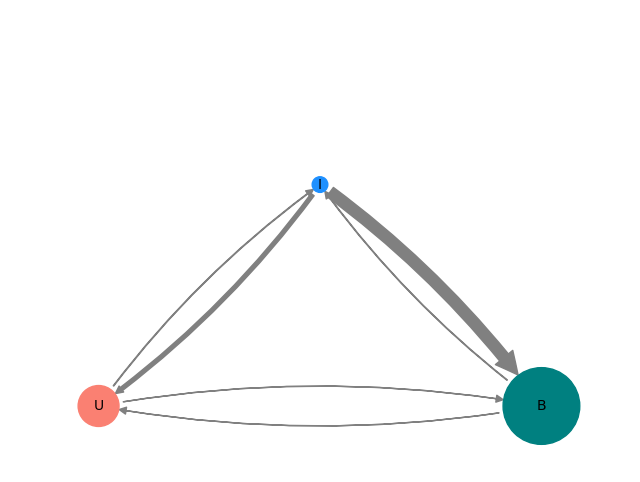

In [60]:
fig,ax=plt.subplots(1, figsize=(8,6))
mplt.plot_markov_model(mmodel, 
                       pos=np.array([[0,0],[1,1],[2,0]]), 
                       state_colors=colors[:pc], state_labels=state_labels,
                       arrow_labels=None, arrow_scale=1.4, ax=ax
                      )
plt.savefig(f'plots/markov_model_{h}_{i}_{cl}_{ml}_{pc}.pdf')
plt.show()

In [61]:
flux = msm.tpt(model, mdis[0], mdis[2])
cg, cgflux = flux.coarse_grain(mdis)
print(cgflux.committor)
paths, path_fluxes = cgflux.pathways(fraction=0.99)
for a,i in enumerate(paths):
    print(i, path_fluxes[a]/np.sum(path_fluxes))

[0.         0.74879837 1.        ]
[0 1 2] 0.8011157588115062
[0 2] 0.19888424118849377


In [62]:
get_frames(model, mdis, dtrj, stds)

([1, 128, 3],
 [array([   931,   2805,   2809, ..., 317700, 317701, 317702]),
  array([    0,     1,     2, ...,  9998,  9999, 10000]),
  array([ 55873,  55886,  55887, ..., 165121, 168403, 169492])])

# h=2, i=3, cl=500, ml=40, pc=3

In [38]:
h=2
i=3
cl=500
ml=40
pc=3

In [39]:
tic2 = np.load(f'ticas/h{h}_tic2_{i}.npz')
tic2 = np.concatenate(([tic2[k] for k in list(tic2)]))

dtrj = np.load(f'urf/saved_h{2}_msm/dtraj_{i}_{cl}.npz')
dtrj = [dtrj[k] for k in list(dtrj)]

model = msm.estimate_markov_model(dtrj, lag=ml)
model.pcca(pc)
mdis=model.metastable_sets
mdis

[array([  0,   2,   3,   4,   6,   8,   9,  10,  11,  12,  14,  15,  16,
         17,  18,  19,  20,  22,  24,  26,  27,  28,  29,  30,  31,  32,
         33,  35,  37,  38,  39,  40,  41,  42,  43,  44,  45,  47,  48,
         50,  51,  52,  53,  54,  55,  56,  57,  59,  61,  62,  63,  66,
         67,  68,  69,  70,  71,  75,  76,  77,  78,  79,  80,  81,  82,
         83,  84,  85,  86,  88,  89,  90,  91,  93,  95,  96,  97,  98,
         99, 100, 101, 102, 103, 104, 105, 106, 107, 110, 111, 112, 113,
        114, 115, 116, 117, 118, 119, 120, 121, 122, 124, 125, 126, 127,
        128, 130, 131, 132, 133, 134, 135, 137, 138, 139, 141, 142, 143,
        144, 145, 146, 148, 149, 150, 151, 152, 154, 155, 156, 157, 158,
        160, 161, 163, 164, 168, 169, 170, 171, 172, 174, 176, 177, 178,
        179, 180, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 193,
        194, 196, 197, 198, 199, 201, 203, 205, 206, 207, 208, 209, 210,
        211, 212, 213, 214, 215, 216, 217, 219, 220

In [40]:
pr = ana.analyze_msm_clusters(dtrj)
pr.take_data(np.load('../1_datasets/mopR_bindings/distance_alldata.npy', allow_pickle=True))
means, stds, probs = pr.get_mean()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 129/129 [00:05<00:00, 25.55it/s]


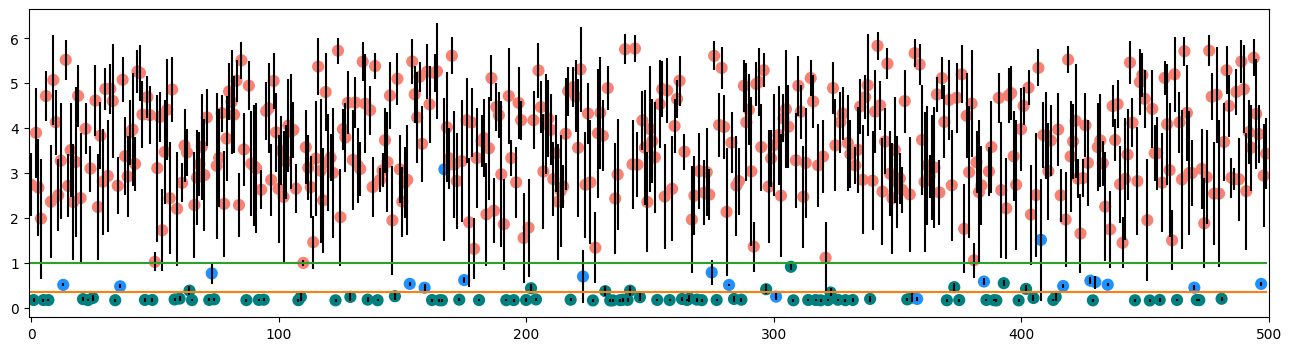

In [41]:
mcolors = np.zeros((cl))
for a,k in enumerate(model.metastable_sets):
    mcolors[k] = a
    
fig,ax=plt.subplots(1, figsize=(16,4))
ax.errorbar(range(cl), means, fmt='.', yerr=stds, ms=0, ecolor='black')
ax.scatter(range(cl), means, c=colors[mcolors.astype(int)], s=60)
ax.plot([0,cl-1],[0.35,0.35])
ax.plot([0,cl-1],[1,1])
ax.set_xlim(-1,cl)
plt.show()

In [42]:
state_labels = ['U','I','B']

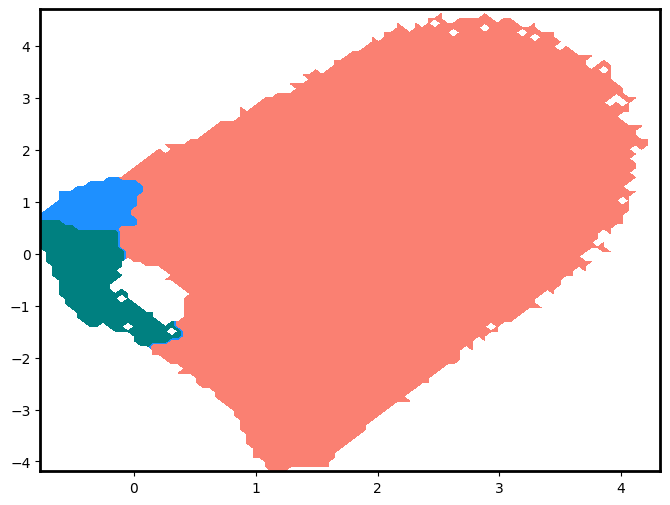

In [43]:
fig,ax=plt.subplots(1,figsize=(8,6))
mplt.plot_state_map(tic2[:,0], tic2[:,1],
                   model.metastable_assignments[np.concatenate((model.dtrajs_active))],
                   cbar=False, cmap=cmaps[pc-3], ax=ax)
ax.spines[:].set_linewidth(2)
plt.savefig(f'plots/statemap_{h}_{i}_{cl}_{ml}_{pc}.pdf')
plt.show()

In [44]:
for a, k in enumerate(mdis): print(a,model.pi[k].sum())

0 0.16724986137884518
1 0.035953234911445094
2 0.7967969037097106


In [45]:
fr = ml * 10 * 10**(-6)
for k in range(pc-1):
    for j in range(k+1,pc):
        print(k,j,model.mfpt(mdis[k], mdis[j])*fr, model.mfpt(mdis[j], mdis[k])*fr)

0 1 7.4824277700901085 29.836054954360456
0 2 9.791943598312196 35.22086868102139
1 2 1.0927627526525512 2.6088999056776028


In [46]:
mdtrj = ana.get_mdtrj(dtrj, mdis, output_type='trj')
mmodel = msm.estimate_markov_model(mdtrj, lag=ml)

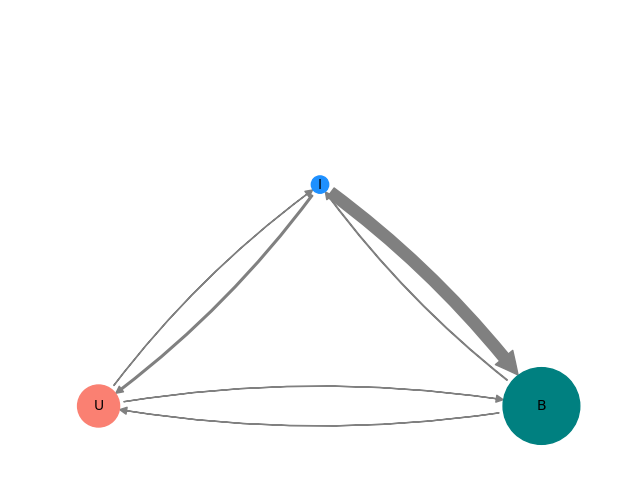

In [47]:
fig,ax=plt.subplots(1, figsize=(8,6))
mplt.plot_markov_model(mmodel, 
                       pos=np.array([[0,0],[1,1],[2,0]]), 
                       state_colors=colors[:pc], state_labels=state_labels,
                       arrow_labels=None, arrow_scale=1.4, ax=ax
                      )
plt.savefig(f'plots/markov_model_{h}_{i}_{cl}_{ml}_{pc}.pdf')
plt.show()

In [49]:
flux = msm.tpt(model, mdis[0], mdis[2])
cg, cgflux = flux.coarse_grain(mdis)
print(cgflux.committor)
paths, path_fluxes = cgflux.pathways(fraction=0.99)
for a,i in enumerate(paths):
    print(i, path_fluxes[a]/np.sum(path_fluxes))

[0.         0.86678843 1.        ]
[0 1 2] 0.6527206667626185
[0 2] 0.3472793332373815


In [50]:
get_frames(model, mdis, dtrj, stds)

([1, 1, 52],
 [array([  5330,   5332,   5333, ..., 313750, 313762, 313788]),
  array([ 79634,  79641,  91783, ..., 280534, 281199, 313708]),
  array([  80,   97,  120, ..., 9483, 9487, 9488])])

# h=2, i=3, cl=700, ml=40, pc=3

In [7]:
h=2
i=3
cl=700
ml=40
pc=3

In [8]:
tic2 = np.load(f'ticas/h{h}_tic2_{i}.npz')
tic2 = np.concatenate(([tic2[k] for k in list(tic2)]))

dtrj = np.load(f'urf/saved_h{2}_msm/dtraj_{i}_{cl}.npz')
dtrj = [dtrj[k] for k in list(dtrj)]

model = msm.estimate_markov_model(dtrj, lag=ml)
model.pcca(pc)
mdis=model.metastable_sets
mdis

[array([  0,   2,   3,   4,   6,   8,   9,  10,  11,  12,  14,  15,  16,
         17,  18,  19,  20,  22,  24,  26,  27,  28,  29,  30,  31,  32,
         33,  35,  37,  38,  39,  40,  41,  42,  43,  44,  45,  47,  48,
         50,  51,  52,  53,  54,  55,  56,  57,  59,  61,  62,  63,  66,
         67,  68,  69,  70,  71,  75,  76,  77,  78,  79,  80,  81,  82,
         83,  84,  85,  86,  88,  89,  90,  91,  93,  95,  96,  97,  98,
         99, 100, 101, 102, 103, 104, 105, 106, 107, 110, 111, 112, 113,
        114, 115, 116, 117, 118, 119, 120, 121, 122, 124, 125, 126, 127,
        128, 130, 131, 132, 133, 134, 135, 137, 138, 139, 141, 142, 143,
        144, 145, 146, 148, 149, 150, 151, 152, 154, 155, 156, 157, 158,
        160, 161, 163, 164, 168, 169, 170, 171, 172, 174, 176, 177, 178,
        179, 180, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 193,
        194, 196, 197, 198, 199, 201, 203, 205, 206, 207, 208, 209, 210,
        211, 212, 213, 214, 215, 216, 217, 219, 220

In [9]:
pr = ana.analyze_msm_clusters(dtrj)
pr.take_data(np.load('../1_datasets/mopR_bindings/distance_alldata.npy', allow_pickle=True))
means, stds, probs = pr.get_mean()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 129/129 [00:05<00:00, 25.24it/s]


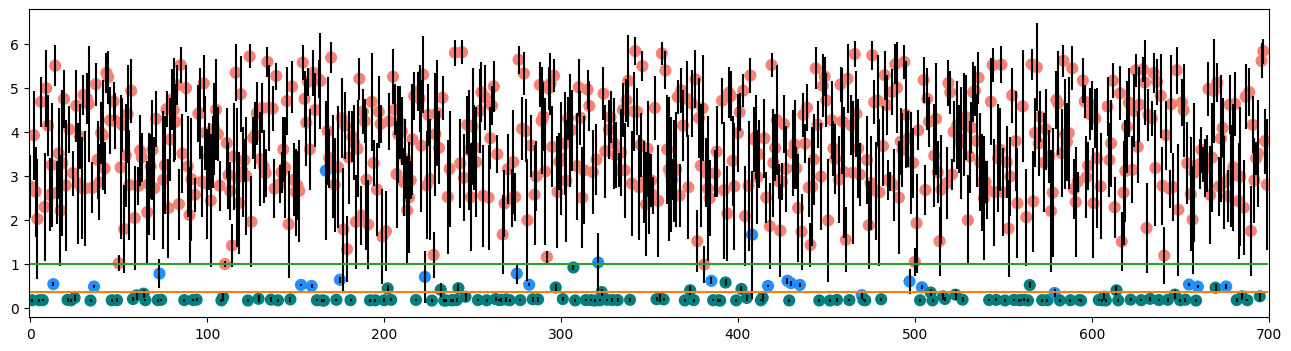

In [10]:
mcolors = np.zeros((cl))
for a,k in enumerate(model.metastable_sets):
    mcolors[k] = a
    
fig,ax=plt.subplots(1, figsize=(16,4))
ax.errorbar(range(cl), means, fmt='.', yerr=stds, ms=0, ecolor='black')
ax.scatter(range(cl), means, c=colors[mcolors.astype(int)], s=60)
ax.plot([0,cl-1],[0.35,0.35])
ax.plot([0,cl-1],[1,1])
ax.set_xlim(-1,cl)
plt.show()

In [11]:
state_labels = ['U','I','B']

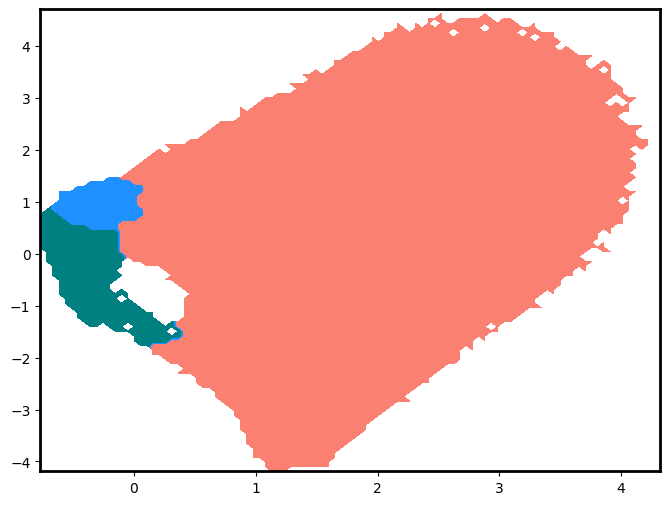

In [12]:
fig,ax=plt.subplots(1,figsize=(8,6))
mplt.plot_state_map(tic2[:,0], tic2[:,1],
                   model.metastable_assignments[np.concatenate((model.dtrajs_active))],
                   cbar=False, cmap=cmaps[pc-3], ax=ax)
ax.spines[:].set_linewidth(2)
plt.savefig(f'plots/statemap_{h}_{i}_{cl}_{ml}_{pc}.pdf')
plt.show()

In [13]:
for a, k in enumerate(mdis): print(a,model.pi[k].sum())

0 0.16456357296116178
1 0.03186765962726586
2 0.8035687674115719


In [14]:
fr = ml * 10 * 10**(-6)
for k in range(pc-1):
    for j in range(k+1,pc):
        print(k,j,model.mfpt(mdis[k], mdis[j])*fr, model.mfpt(mdis[j], mdis[k])*fr)

0 1 7.707177784149731 32.59475651754265
0 2 9.978436951815004 38.944498970805135
1 2 1.2426208293281342 5.767005066340358


In [15]:
mdtrj = ana.get_mdtrj(dtrj, mdis, output_type='trj')
mmodel = msm.estimate_markov_model(mdtrj, lag=ml)

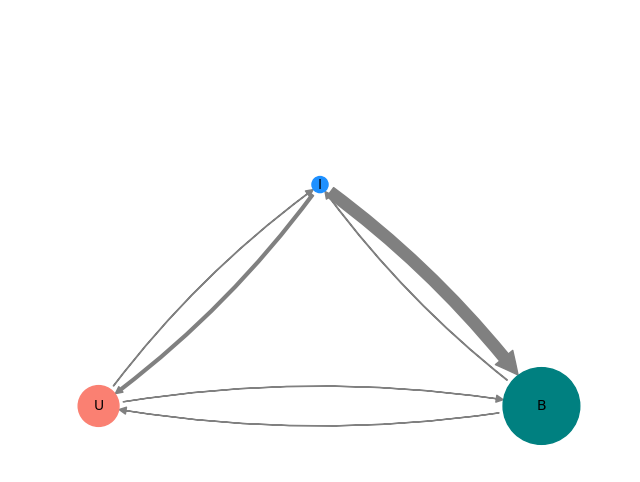

In [16]:
fig,ax=plt.subplots(1, figsize=(8,6))
mplt.plot_markov_model(mmodel, 
                       pos=np.array([[0,0],[1,1],[2,0]]), 
                       state_colors=colors[:pc], state_labels=state_labels,
                       arrow_labels=None, arrow_scale=1.4, ax=ax
                      )
plt.savefig(f'plots/markov_model_{h}_{i}_{cl}_{ml}_{pc}.pdf')
plt.show()

In [17]:
flux = msm.tpt(model, mdis[0], mdis[2])
cg, cgflux = flux.coarse_grain(mdis)
print(cgflux.committor)
paths, path_fluxes = cgflux.pathways(fraction=0.99)
for a,i in enumerate(paths):
    print(i, path_fluxes[a]/np.sum(path_fluxes))

[0.         0.86355488 1.        ]
[0 1 2] 0.6299903121986147
[0 2] 0.37000968780138527


In [18]:
get_frames(model, mdis, dtrj, stds)

([1, 1, 89],
 [array([  5337,   5350,   5365,   5420,   5461,   5488,   5497,   5499,
           5502,   5512,   5522,   5539,   5551,   5586,   5588,   5604,
           5611,   5624,   5629,   5631,   5632,   5636,   5666,   5688,
           5691,   5692,   5695,   5698,   5706,   5736,  16183,  16186,
          16205,  16222,  16304,  16356,  16360,  16361,  16378,  16381,
          16383,  16412,  16468,  16470,  16472,  16487,  16500,  16509,
          16550,  16561,  16572,  16638,  16671,  16674,  16689,  16708,
          16727,  16751,  16758,  16759,  16764,  16787,  16824,  16825,
          16864,  16886,  16893,  16905,  16964,  16970,  16972,  16979,
          17015,  17097,  17105,  17115,  17140,  17163,  17208,  17257,
          17276,  17291,  17301,  17323,  17324,  17326,  17334,  17340,
          17342,  17343,  17355,  17356,  17357,  17382,  17402,  17457,
          17480,  17502,  17524,  17534,  17549,  17562,  17580,  17610,
          17613,  17616,  17617,  1762

# h=2, i=3, cl=1000, ml=40, pc=3

In [19]:
h=2
i=3
cl=700
ml=40
pc=3

In [20]:
tic2 = np.load(f'ticas/h{h}_tic2_{i}.npz')
tic2 = np.concatenate(([tic2[k] for k in list(tic2)]))

dtrj = np.load(f'urf/saved_h{2}_msm/dtraj_{i}_{cl}.npz')
dtrj = [dtrj[k] for k in list(dtrj)]

model = msm.estimate_markov_model(dtrj, lag=ml)
model.pcca(pc)
mdis=model.metastable_sets
mdis

[array([  0,   2,   3,   4,   6,   8,   9,  10,  11,  12,  14,  15,  16,
         17,  18,  19,  20,  22,  24,  26,  27,  28,  29,  30,  31,  32,
         33,  35,  37,  38,  39,  40,  41,  42,  43,  44,  45,  47,  48,
         50,  51,  52,  53,  54,  55,  56,  57,  59,  61,  62,  63,  66,
         67,  68,  69,  70,  71,  75,  76,  77,  78,  79,  80,  81,  82,
         83,  84,  85,  86,  88,  89,  90,  91,  93,  95,  96,  97,  98,
         99, 100, 101, 102, 103, 104, 105, 106, 107, 110, 111, 112, 113,
        114, 115, 116, 117, 118, 119, 120, 121, 122, 124, 125, 126, 127,
        128, 130, 131, 132, 133, 134, 135, 137, 138, 139, 141, 142, 143,
        144, 145, 146, 148, 149, 150, 151, 152, 154, 155, 156, 157, 158,
        160, 161, 163, 164, 168, 169, 170, 171, 172, 174, 176, 177, 178,
        179, 180, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 193,
        194, 196, 197, 198, 199, 201, 203, 205, 206, 207, 208, 209, 210,
        211, 212, 213, 214, 215, 216, 217, 219, 220

In [21]:
pr = ana.analyze_msm_clusters(dtrj)
pr.take_data(np.load('../1_datasets/mopR_bindings/distance_alldata.npy', allow_pickle=True))
means, stds, probs = pr.get_mean()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 129/129 [00:05<00:00, 25.47it/s]


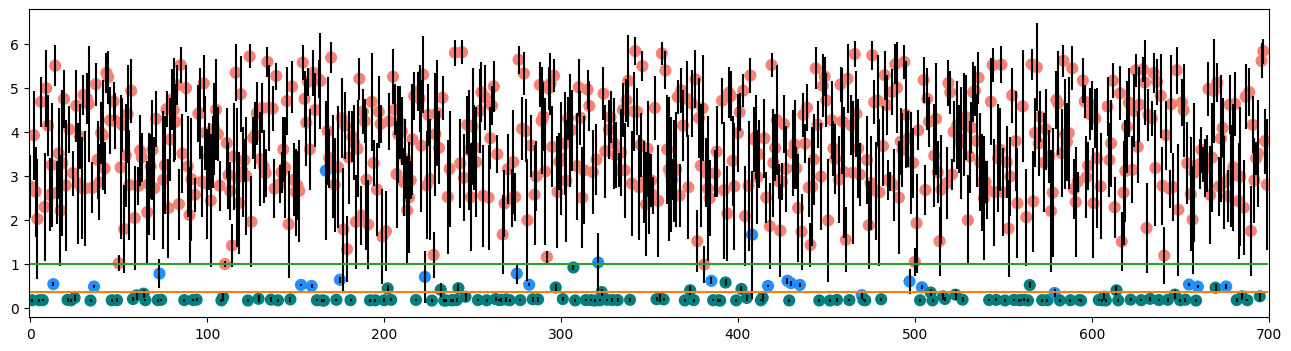

In [22]:
mcolors = np.zeros((cl))
for a,k in enumerate(model.metastable_sets):
    mcolors[k] = a
    
fig,ax=plt.subplots(1, figsize=(16,4))
ax.errorbar(range(cl), means, fmt='.', yerr=stds, ms=0, ecolor='black')
ax.scatter(range(cl), means, c=colors[mcolors.astype(int)], s=60)
ax.plot([0,cl-1],[0.35,0.35])
ax.plot([0,cl-1],[1,1])
ax.set_xlim(-1,cl)
plt.show()

In [23]:
state_labels=['U','I','B']

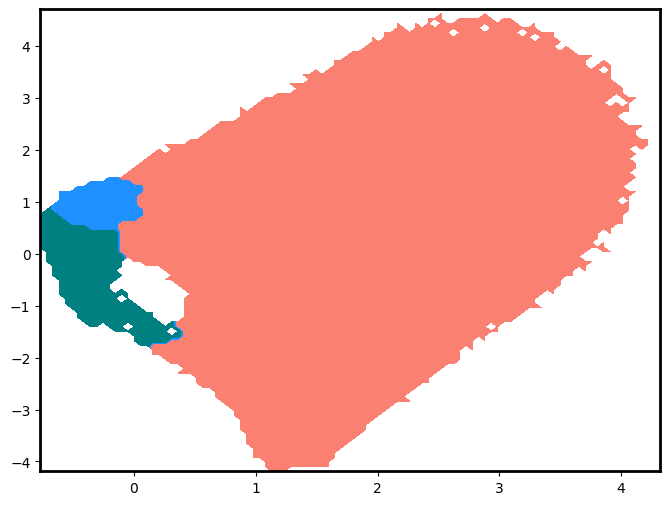

In [24]:
fig,ax=plt.subplots(1,figsize=(8,6))
mplt.plot_state_map(tic2[:,0], tic2[:,1],
                   model.metastable_assignments[np.concatenate((model.dtrajs_active))],
                   cbar=False, cmap=cmaps[pc-3], ax=ax)
ax.spines[:].set_linewidth(2)
plt.savefig(f'plots/statemap_{h}_{i}_{cl}_{ml}_{pc}.pdf')
plt.show()

In [25]:
for a, k in enumerate(mdis): print(a,model.pi[k].sum())

0 0.16456357296116178
1 0.03186765962726586
2 0.8035687674115719


In [26]:
fr = ml * 10 * 10**(-6)
for k in range(pc-1):
    for j in range(k+1,pc):
        print(k,j,model.mfpt(mdis[k], mdis[j])*fr, model.mfpt(mdis[j], mdis[k])*fr)

0 1 7.707177784149731 32.59475651754265
0 2 9.978436951815004 38.944498970805135
1 2 1.2426208293281342 5.767005066340358


In [27]:
mdtrj = ana.get_mdtrj(dtrj, mdis, output_type='trj')
mmodel = msm.estimate_markov_model(mdtrj, lag=ml)

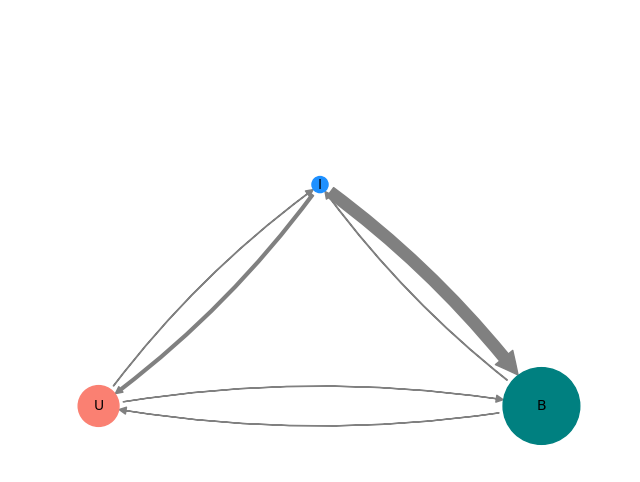

In [28]:
fig,ax=plt.subplots(1, figsize=(8,6))
mplt.plot_markov_model(mmodel, 
                       pos=np.array([[0,0],[1,1],[2,0]]), 
                       state_colors=colors[:pc], state_labels=state_labels,
                       arrow_labels=None, arrow_scale=1.4, ax=ax
                      )
plt.savefig(f'plots/markov_model_{h}_{i}_{cl}_{ml}_{pc}.pdf')
plt.show()

In [29]:
flux = msm.tpt(model, mdis[0], mdis[2])
cg, cgflux = flux.coarse_grain(mdis)
print(cgflux.committor)
paths, path_fluxes = cgflux.pathways(fraction=0.99)
for a,i in enumerate(paths):
    print(i, path_fluxes[a]/np.sum(path_fluxes))

[0.         0.86355488 1.        ]
[0 1 2] 0.6299903121986147
[0 2] 0.37000968780138527


In [30]:
get_frames(model, mdis, dtrj, stds)

([1, 1, 89],
 [array([  5337,   5350,   5365,   5420,   5461,   5488,   5497,   5499,
           5502,   5512,   5522,   5539,   5551,   5586,   5588,   5604,
           5611,   5624,   5629,   5631,   5632,   5636,   5666,   5688,
           5691,   5692,   5695,   5698,   5706,   5736,  16183,  16186,
          16205,  16222,  16304,  16356,  16360,  16361,  16378,  16381,
          16383,  16412,  16468,  16470,  16472,  16487,  16500,  16509,
          16550,  16561,  16572,  16638,  16671,  16674,  16689,  16708,
          16727,  16751,  16758,  16759,  16764,  16787,  16824,  16825,
          16864,  16886,  16893,  16905,  16964,  16970,  16972,  16979,
          17015,  17097,  17105,  17115,  17140,  17163,  17208,  17257,
          17276,  17291,  17301,  17323,  17324,  17326,  17334,  17340,
          17342,  17343,  17355,  17356,  17357,  17382,  17402,  17457,
          17480,  17502,  17524,  17534,  17549,  17562,  17580,  17610,
          17613,  17616,  17617,  1762